# Try a Progressive Deep Convolutional Generative Adversarial Network on DDSM Dataset

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image
from torch.autograd import Variable

import itertools


In [2]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Hyperparameters

In [3]:
# Root directory for dataset
dataroot='/clio/users/olgakr/DDSM/new_labels/2class/'
dataroot2= '/clio/users/olgakr/DDSM/ddsm_patches/'

# Number of workers for dataloader
num_workers = 12

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 16

# Size of feature maps in discriminator
ndf = 16

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

# Load the data & create a DataLoader

In [4]:
class DDSM(torch.utils.data.Dataset):
    def __init__(self, root1, root2, split, transform):
        self.root1 = root1
        self.root2 = root2
        def process_line(line):
            if 'normal' in line:
                image_name, label = line.strip().split(' ')
                label = int(label)
                return image_name, label
        with open(os.path.join(root1, '{}.txt'.format(split)), 'r') as f:
            for line in f:
                if 'normal' in line:
                    self.image_list = (list(map(process_line, f.readlines())))
            
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name, label = self.image_list[idx]
        image = Image.open(os.path.join(self.root2, image_name)) #.convert("L")
        image = self.transform(image)
        
        return image, label
    

transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize([64,64]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = DDSM(dataroot, dataroot2, 'train',  transform=transform)



train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

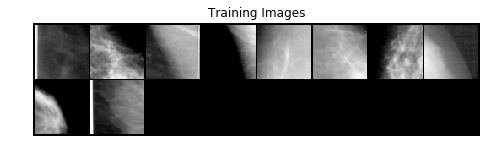

In [5]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
real_batch[0].shape 

torch.Size([64, 1, 64, 64])

#  Weight initialization for both Generator and Discriminator

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Class Generator

In [8]:
class encoder(nn.Module):
    def __init__(self, ngpu):
        super(encoder, self).__init__()
        self.ngpu = ngpu
        #input 1x64x64
        self.conv1 = nn.Conv2d(nc, ngf*4, 3, 1, 1, bias=False) # one channel for the image one for the mask
        self.bn1 = nn.BatchNorm2d(ngf*4)   
        #first layer ngf x 64 x 64
        self.conv2 = nn.Conv2d(ngf*4, ngf * 8, 4, 2, 1, bias=False)  # second layer will be concatenated (remember x and y)
        self.bn2 = nn.BatchNorm2d(ngf*8)
        #second layer ngf*2 x 32 x 32
        self.conv3 = nn.Conv2d(ngf*8, ngf*16, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 16)
        #third layer ngf*4 x 16 x 16
        self.conv4 =  nn.Conv2d( ngf * 16, ngf * 32, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf * 32)
        #forth layer ngf*8 x 8 x 8
        self.conv5 =  nn.Conv2d( ngf * 32, ngf * 64, 4, 2, 1, bias=False)
        
        #fifth layer ngf*16 x 4 x 4
            
    def forward(self, input):
        x = F.leaky_relu(self.bn1(self.conv1(input)), 0.2)
        #print('1: ', x.shape)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        #print('2: ', x.shape)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        #print('3: ', x.shape)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        #print('4: ', x.shape)
        x = torch.tanh(self.conv5(x))
        #print('5: ', x.shape)
        return x
            
            
            
class decoder(nn.Module):
    def __init__(self, ngpu):
        super(decoder, self).__init__()
        self.ngpu = ngpu
        #input 1024x4x4               
        self.dec1 =  nn.ConvTranspose2d( ngf * 64 , ngf * 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 64)
        #1st layer 1024 x 4 x 4
        self.dec2 = nn.ConvTranspose2d(ngf * 64, ngf * 64, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 64)
        #2nd layer 1024 x 4 x 4
        self.dec3 = nn.ConvTranspose2d(ngf * 64, ngf * 32, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 32)
        #3rd layer 512 x 4 x 4
        self.dec4 = nn.ConvTranspose2d(ngf * 32, ngf * 32, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf * 32)
        #4th layer 512 x 8 x 8
        self.dec5 = nn.ConvTranspose2d(ngf * 32, ngf * 32, 3, 1, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf * 32)
        #5th layer 512 x 8 x 8
        self.dec6 = nn.ConvTranspose2d(ngf * 32, ngf * 16, 3, 1, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ngf * 16)
        #6th layer 256 x 8 x 8
        self.dec7 = nn.ConvTranspose2d(ngf * 16, ngf * 16, 4, 2, 1, bias=False)
        self.bn7 = nn.BatchNorm2d(ngf * 16)
        #7th layer 256 x 16 x 16
        self.dec8 = nn.ConvTranspose2d(ngf * 16, ngf * 16, 3, 1, 1, bias=False)
        self.bn8 = nn.BatchNorm2d(ngf * 16)
        #8th layer 256 x 16 x 16
        self.dec9 = nn.ConvTranspose2d(ngf * 16, ngf * 8, 3, 1, 1, bias=False)
        self.bn9 = nn.BatchNorm2d(ngf * 8)
        #9th layer 128 x 16 x 16
        self.dec10 = nn.ConvTranspose2d(ngf * 8, ngf * 8, 4, 2, 1, bias=False)
        self.bn10 = nn.BatchNorm2d(ngf * 8)
        #10th layer 128 x 32 x 32
        self.dec11 = nn.ConvTranspose2d(ngf * 8, ngf * 8, 3, 1, 1, bias=False)
        self.bn11 = nn.BatchNorm2d(ngf * 8)
        #11th layer 128 x 32 x 32
        self.dec12 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False)
        self.bn12 = nn.BatchNorm2d(ngf * 4)
        #12th layer 64 x 32 x 32
        self.dec13 = nn.ConvTranspose2d(ngf * 4, ngf * 4, 4, 2, 1, bias=False)
        self.bn13 = nn.BatchNorm2d(ngf * 4)
        #13th layer 64 x 64 x 64
        self.dec14 = nn.ConvTranspose2d(ngf * 4, ngf * 4, 3, 1, 1, bias=False)
        self.bn14 = nn.BatchNorm2d(ngf * 4)
        #14th layer 64 x 64 x 64
        self.dec15 = nn.Linear(ngf*4, nc)
        #15th layer 1 x 64 x 64
            
            
    def forward(self, input):
        x = F.relu(self.bn1(self.dec1(input)))
        #print('1: ', x.shape)
        
        x = F.relu(self.bn2(self.dec2(x)))
        #print('2: ', x.shape)
        x = F.relu(self.bn3(self.dec3(x)))
        #print('3: ', x.shape)
        x = F.relu(self.bn4(self.dec4(x)))
        #print('4: ', x.shape)
        x = F.relu(self.bn5(self.dec5(x)))
        #print('5: ', x.shape)
        x = F.relu(self.bn6(self.dec6(x)))
        #print('6: ', x.shape)
        x = F.relu(self.bn7(self.dec7(x)))
        #print('7: ', x.shape)
        x = F.relu(self.bn8(self.dec8(x)))
        #print('23: ', x.shape)
        x = F.relu(self.bn9(self.dec9(x)))
        #print('9: ', x.shape)
        x = F.relu(self.bn10(self.dec10(x)))
        #print('10: ', x.shape)
        x = F.relu(self.bn11(self.dec11(x)))
        #print('11: ', x.shape)
        x = F.relu(self.bn12(self.dec12(x)))
        #print('12: ', x.shape)
        x = F.relu(self.bn13(self.dec13(x)))
        #print('13: ', x.shape)
        x = F.relu(self.bn14(self.dec14(x)))
        #print('14: ', x.shape)
        x = self.dec15(x)
        #print('15: ', x.shape)

        return x
    
    
    
    
    

In [9]:
# Create the encoder
encoder = encoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    encoder = nn.DataParallel(encoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
encoder.apply(weights_init)

# Print the model
print(encoder)

DataParallel(
  (module): encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


In [10]:
# Create the decoder
decoder = decoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    decoder = nn.DataParallel(decoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
decoder.apply(weights_init)

# Print the model
print(decoder)

DataParallel(
  (module): decoder(
    (dec1): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec2): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec4): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec5): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [11]:
#netG(real_batch[0])

# Class Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
      
        self.dec1 = nn.Conv2d(nc, ngf * 16, 1, 1, 0, bias=False) # one channel for the image one for the mask   
        #first layer 256 x 64 x 64
        self.dec2 = nn.Conv2d(ngf * 16, ngf * 16, 3, 1, 1, bias=False)  # second layer will be concatenated (remember x and y)
        self.bn2 = nn.BatchNorm2d(ngf * 16)
        #second layer 256 x 64 x 64
        self.dec3 = nn.Conv2d(ngf * 16, ngf * 32, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 32)
        #third layer 512 x 64 x 64
        self.dec4 =  nn.Conv2d( ngf * 32, ngf * 32, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf * 32)
        #forth layer 512 x 32 x 32
        self.dec5 =  nn.Conv2d( ngf * 32, ngf * 32, 3, 1, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf * 32)
        #fifth layer 512 x 32 x 32
        self.dec6 =  nn.Conv2d( ngf * 32, ngf * 32, 3, 1, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ngf * 32)
        #sixthlayer 512 x 32 x 32
        self.dec7 =  nn.Conv2d( ngf * 32, ngf * 32, 4, 2, 1, bias=False)
        self.bn7 = nn.BatchNorm2d(ngf * 32)
        #seventh layer 512 x 16 x 16
        self.dec8 =  nn.Conv2d( ngf * 32, ngf * 32, 3, 1, 1, bias=False)
        self.bn8 = nn.BatchNorm2d(ngf * 32)
        #eighth layer 512 x 16 x 16
        self.dec9 =  nn.Conv2d( ngf * 32, ngf * 32, 3, 1, 1, bias=False)
        self.bn9 = nn.BatchNorm2d(ngf * 32)
        #nineth layer 512 x 16 x 16
        self.dec10 =  nn.Conv2d( ngf * 32 , ngf * 32, 4, 2, 1, bias=False)
        self.bn10 = nn.BatchNorm2d(ngf * 32)
        #tenth layer 512 x 8 x 8
        self.dec11 =  nn.Conv2d( ngf * 32, ngf * 32, 3, 1, 1, bias=False)
        self.bn11 = nn.BatchNorm2d(ngf * 32)
        #eleventh layer 512 x 8 x 8
        self.dec12 =  nn.Conv2d( ngf * 32, ngf * 32, 3, 1, 1, bias=False)
        self.bn12 = nn.BatchNorm2d(ngf * 32)
        #twelveth layer 512 x 8 x 8
        self.dec13 =  nn.Conv2d( ngf * 32 , ngf * 32, 4, 2, 1, bias=False)
        self.bn13 = nn.BatchNorm2d(ngf * 32)
        #thirteenth layer 512 x 4 x 4
        self.dec14 =  nn.Conv2d( ngf * 32 , ngf * 32, 3, 1, 1, bias=False)
        self.bn14 = nn.BatchNorm2d(ngf * 32)
        #fourteenth layer 512 x 4 x 4
        self.dec15 =  nn.Conv2d( ngf * 32 , ngf * 32, 3, 1, 1, bias=False)
        self.bn15 = nn.BatchNorm2d(ngf * 32)
        #fifteenth layer 512 x 4 x 4
        self.dec16 =  nn.Conv2d( ngf * 32 , ngf * 32, 4, 1, 0, bias=False)
        self.bn16 = nn.BatchNorm2d(ngf * 32)
        #16th layer 512 x 1 x 1
        self.dec17 = nn.Conv2d(ndf *32 , 1, 1, 1, 0, bias=False)
        #17th layer 1
        
        self.fc = nn.Linear(1*1*1,1)
        
        
    def forward(self, input):
        
        x = F.leaky_relu(self.dec1(input), 0.2)
        #print('1: ', x.shape)
        x = F.leaky_relu(self.bn2(self.dec2(x)),0.2)
        #print('2: ', x.shape)
        x = F.leaky_relu(self.bn3(self.dec3(x)),0.2)
        #print('3: ', x.shape)
        x = F.leaky_relu(self.bn4(self.dec4(x)),0.2)
        #print('4: ', x.shape)
        x = F.leaky_relu(self.bn5(self.dec5(x)),0.2)
        #print('5: ', x.shape)
        x = F.leaky_relu(self.bn6(self.dec6(x)), 0.2)
        #print('6: ', x.shape)
        x = F.leaky_relu(self.bn7(self.dec7(x)),0.2)
        #print('7: ', x.shape)
        x = F.leaky_relu(self.bn8(self.dec8(x)),0.2)
        #print('8: ', x.shape)
        x = F.leaky_relu(self.bn9(self.dec9(x)),0.2)
        #print('9: ', x.shape)
        x = F.leaky_relu(self.bn10(self.dec10(x)),0.2)
        #print('10: ', x.shape)
        x = F.leaky_relu(self.bn11(self.dec11(x)), 0.2)
        #print('11: ', x.shape)
        x = F.leaky_relu(self.bn12(self.dec12(x)),0.2)
        #print('12: ', x.shape)
        x = F.leaky_relu(self.bn13(self.dec13(x)),0.2)
        #print('13: ', x.shape)
        x = F.leaky_relu(self.bn14(self.dec14(x)),0.2)
        #print('14: ', x.shape)
        x = F.leaky_relu(self.bn15(self.dec15(x)),0.2)
        #print('15: ', x.shape)
        x = F.leaky_relu(self.bn16(self.dec16(x)), 0.2)
        #print('16: ', x.shape)
        x = F.leaky_relu(self.dec17(x), 0.2)
        #print('16: ', x.shape)
        x = torch.sigmoid(self.fc(x))
        #print(x.shape)
        return x
        
    

    
    

        

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (dec1): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (dec2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

In [14]:
#netD(netG(real_batch[0]))

In [15]:
adversarial_loss = torch.nn.BCELoss()
adversarial_loss = adversarial_loss.to(device)
pixelwise_loss = torch.nn.L1Loss()
pixelwise_loss = pixelwise_loss.to(device)

In [17]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(beta1, 0.999))

In [18]:
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0
fake_labels = torch.zeros(batch_size, 1)


label = torch.FloatTensor(batch_size).to(device)

In [20]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
    
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
       
        #print('real:',real_cpu.shape)  # shape of the image tensor
        b_size = real_cpu.size(0)
        
        label = torch.full((b_size,), real_label).to(device)
        #print('label shape:', label.shape)  # shape of the real label tensor
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)  
        #print(output)
          
        #print('output shape:', output.shape) # shape of the generated label tensor
        # Calculate loss on all-real batch
        errD_real = adversarial_loss(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()  # the output of real images has to be close to 1 (prob for real close to 1)

        
        
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        
        # Generate fake image batch with G
        encoded_imgs = encoder(real_cpu)
        fake = decoder(encoded_imgs).reshape(b_size, nc, 64, 64)
        
        #print('fake:',fake.shape)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        #print(label.shape)
        #print(output.shape)
        # Calculate D's loss on the all-fake batch
        errD_fake = adversarial_loss(output, label)  ### Label = 0 since it's fake, if D is good output should also be around 0
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()   # the output of fake images has to be close to 0 (prob for fake close to 0)
        
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake  ## a high score means a good discriminator (look on the DmaxGmin equation)
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        encoder.zero_grad()
        decoder.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = 0.001* (adversarial_loss(output, label)) + 0.999 * (pixelwise_loss(fake, real_cpu)) ### Label = 1 since it's real labels, if G is good output should be around 1
                                         ## That means that G tricks the D 
        # Calculate gradients for G
        #reset_grad() do I need this?
        errG.backward()
        D_G_z2 = output.mean().item()  
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on generated images
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                encoded_imgs = encoder(real_batch[0].to(device))
                fake = (decoder(encoded_imgs)).reshape(batch_size, nc, 64, 64)
            img_list.append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[1/1][0/1474]	Loss_D: 1.4402	Loss_G: 0.5583	D(x): 0.5893	D(G(z)): 0.5926 / 0.6268
[1/1][50/1474]	Loss_D: 1.1898	Loss_G: 0.1710	D(x): 0.6964	D(G(z)): 0.5293 / 0.5286
[1/1][100/1474]	Loss_D: 1.1261	Loss_G: 0.1687	D(x): 0.7375	D(G(z)): 0.5323 / 0.5305
[1/1][150/1474]	Loss_D: 1.2176	Loss_G: 0.1344	D(x): 0.6388	D(G(z)): 0.5250 / 0.5276
[1/1][200/1474]	Loss_D: 1.7053	Loss_G: 0.1478	D(x): 0.7548	D(G(z)): 0.7093 / 0.5263
[1/1][250/1474]	Loss_D: 1.0828	Loss_G: 0.1483	D(x): 0.7655	D(G(z)): 0.5315 / 0.5242
[1/1][300/1474]	Loss_D: 1.3037	Loss_G: 0.1521	D(x): 0.6596	D(G(z)): 0.5578 / 0.5143
[1/1][350/1474]	Loss_D: 1.1589	Loss_G: 0.1397	D(x): 0.7026	D(G(z)): 0.5265 / 0.5191
[1/1][400/1474]	Loss_D: 0.9956	Loss_G: 0.1298	D(x): 0.8152	D(G(z)): 0.5111 / 0.4959
[1/1][450/1474]	Loss_D: 1.5157	Loss_G: 0.1144	D(x): 0.5802	D(G(z)): 0.5806 / 0.5611
[1/1][500/1474]	Loss_D: 1.3841	Loss_G: 0.1048	D(x): 0.5680	D(G(z)): 0.5459 / 0.5073
[1/1][550/1474]	Loss_D: 1.1729	Loss_G: 0.1430	D(x): 0

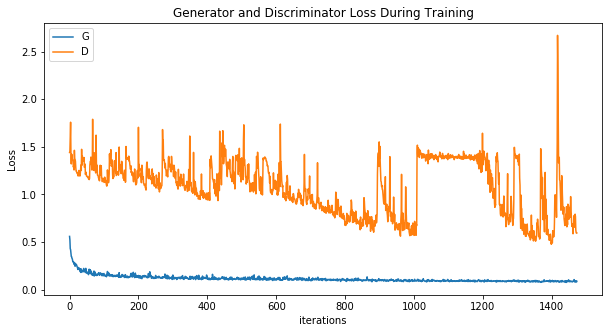

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

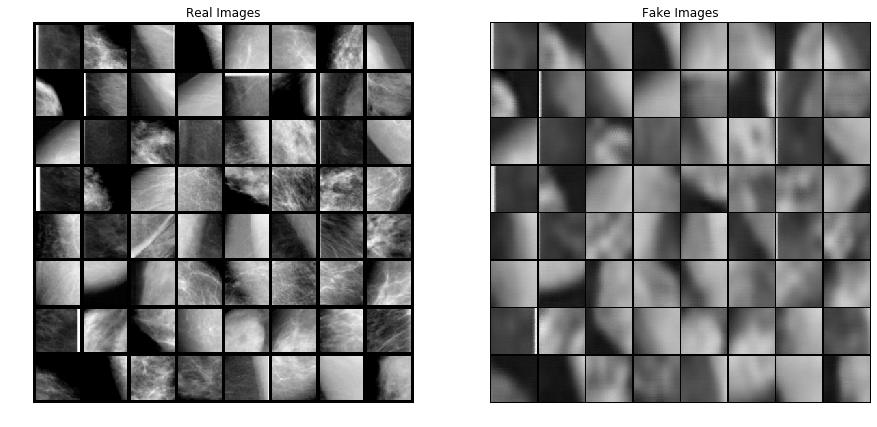

In [22]:

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))  
plt.show()

In [21]:
encoder.eval()

DataParallel(
  (module): encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [22]:
decoder.eval()

DataParallel(
  (module): decoder(
    (dec1): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec2): ConvTranspose2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec4): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec5): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [23]:
test_dataset = DDSM(dataroot, dataroot2, 'test',  transform=transform)



test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

In [24]:
test_batch = next(iter(test_loader))

In [25]:
encoded_imgs = encoder(test_batch[0].to(device))
fakes = decoder(encoded_imgs)

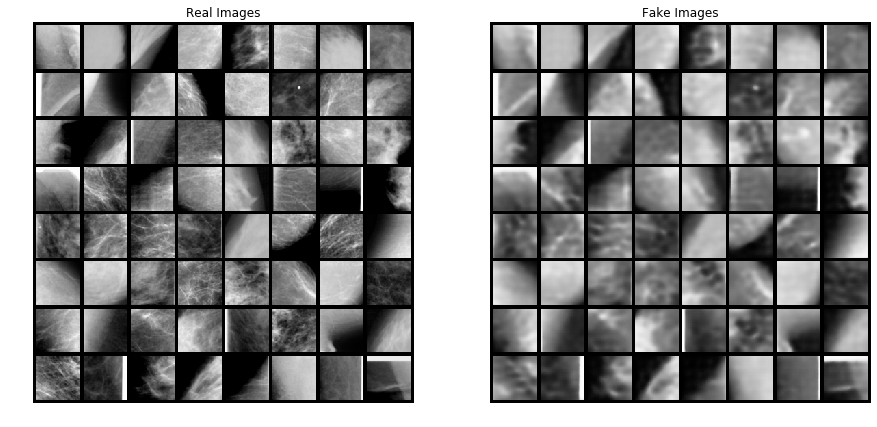

In [26]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fakes.detach().to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()